<a href="https://colab.research.google.com/github/lavanaythakral/GPT2-answers/blob/master/Semantic_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prerequisites

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
from google.colab import drive
import scipy
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data

In [77]:
filename = "/content/drive/My Drive/Thesis project/Thesis project/datasets/post BERT/responses_B.csv"

In [78]:
df = pd.read_csv(filename)
df.head(5)

,Question,Answer
0,Why do we create Art?,This is beyond my knowledge but here's what I ...
1,What is free will?,This is beyond my knowledge but here's what I ...
2,What is freedom,This is beyond my knowledge but here's what I ...
3,What is truth?,there is a great deal that most of us can indi...
4,What is the soul?,Nandi


In [79]:
questions = list(df['Question'])
answers = list(df['Answer'])

In [ ]:
len(questions)

#Sentence Tranformers

In [11]:
!pip install -U sentence-transformers

     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 1.1MB 14.6MB/s 
     |████████████████████████████████| 1.1MB 29.4MB/s 
     |████████████████████████████████| 3.0MB 17.0MB/s 
     |████████████████████████████████| 890kB 57.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.7.1-cp36-none-any.whl size=91224 sha256=62848a10615d652bbad5798709ac6c2c4273a1c50e81ca2dc33ef8c3828b2198
  Stored in directory: /root/.cache/pip/wheels/05/88/41/2d19aed5fe1e4b03f0271fcf355450e8a968c810b93f0ec5af
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=191bd19424bd5717fbe9ef0f53f322c864d8cd2381f66ce05a8ad9d73aee4e9d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [12]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:05<00:00, 72.7MB/s]


In [13]:
#s1,s2 are strings
def calculate(s1,s2):
  e1 = model.encode([s1])
  e2 = model.encode([s2])
  distance = scipy.spatial.distance.cdist([e1[0]], [e2[0]], "cosine")[0]
  return distance[0]

In [14]:
def verification(questions,answers):
  scores = []
  for ques,ans in zip(questions,answers):
    scores.append(calculate(ques,ans))
  return scores

#Removing outliers

In [69]:
def set_range(questions,answers):
  v = verification(questions,answers)
  fig = plt.figure(figsize =(10, 7))  
  res = plt.boxplot(v) 
  min = (res['whiskers'][0].get_ydata()[0] + res['whiskers'][0].get_ydata()[1])/2
  max = (res['whiskers'][1].get_ydata()[1] + res['whiskers'][1].get_ydata()[0])/2
  print(min,max)
  plt.show() 
  return [res['boxes'][0].get_ydata()[1],res['boxes'][0].get_ydata()[2]]

0.28025610141010693 0.7643773120492392


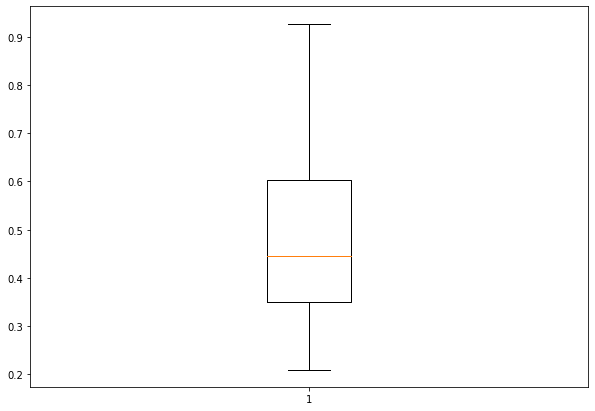

[0.3504501328142715, 0.6017759121227042]

In [70]:
set_range(questions,answers)

In [35]:
def refine(df):
  questions = list(df['Question'])
  answ1 = list(df['Answer'])
  answers = []
  for ans in answ1:
    answers.append(ans.replace("This is beyond my knowledge but here's what I think.",""))
  
  scores = verification(questions,answers)
  df['scores'] = scores
  min,max = set_range(questions,answers)
  print(min,max)
  rows = []
  predictions = {}
  for idx,(ques,ans,score) in enumerate(zip(questions,answers,scores)):
    if(score >= min and score <= max):
      dict1 = {}
      dict1['Question'] = ques
      dict1['Answer'] = ans
      predictions[str(idx)] = ans
      rows.append(dict1)
  return pd.DataFrame(rows),json.dumps(predictions,indent = 1)

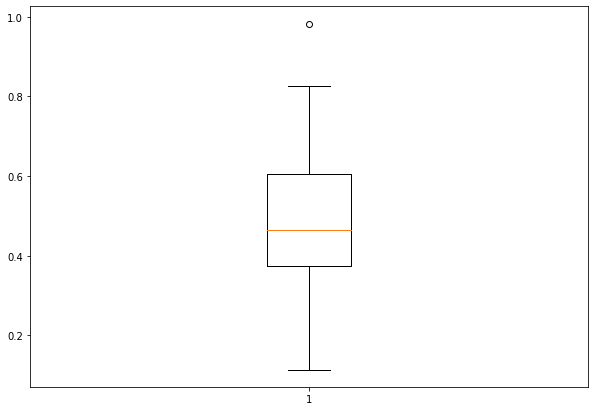

0.37366467832547456 0.6045966820785118


In [36]:
df_range,predictions = refine(df)

In [ ]:
with open("/content/drive/My Drive/Thesis project/Thesis project/datasets/post BERT/pred_regen_philosophy.json","w") as f:
  f.write(predictions)